# EDA (Exploratory Data Analysis)

In this notebook I explore the data visually and try to pick out some insights from the data.

## Notes
### Outliers and Visualisation
Most plots of model loss are truncated since there are a number of massive outliers that make the interesting parts of the data hard to see (esp. when using the ReLU activation with a high learning rate).

### Incomparability of Regression and Classification Task Results
Since the regression tasks and classification tasks use different metrics, it is hard to directly compare the performance of the models accross both tasks. This is due the use of Pearson's R and RMSE in regression, whereas log loss and accuracy are being used for classification. As such, I would believe it best to consider models doing regression separately from models classification.

### Invalidity of Scoring Metric for Regression Tasks
The scoring metric used for evaluating the regression type models was Pearson's Correlation Coefficient (PCC):
![Pearson's Correlation Coefficient](https://wikimedia.org/api/rest_v1/media/math/render/svg/2b9c2079a3ffc1aacd36201ea0a3fb2460dc226f)
Here $x$ would be the target labels and $y$ the predicted labels.

Due to the unfortunate combination of PCC with SGD and binary valued spaces, many of the scores produced for the regression based models are likely erroneous. This is largely due to small batch sizes producing unfortunate combinations of output labels. For example, in the XOR problem if using a batch size of two, one may encounter the pair of target labels 0 and 0 (with inputs of [0, 0] and [1, 1]). The outputs of course have a variance of zero and we get a demonator of zero (see the equation above). 

I thought it was a good idea to add a small value $\epsilon$ to the denominator so if the variance was zero I would not get a divide by zero error, and instead get a value very close to zero. Although, this may have been a bad idea in the end since more *'genuine'* PCC scores very close to zero would be indistinguishable from these erroneous zero PCC scores.

Another problem is that with SGD you process one training pattern at a time. This is problematic when it comes to evaluating the PCC since $\bar{x}=x$ and $\bar{y}=y$, therefore the numerator will equal zero.

Using the $R^2$ metric (a.k.a. the Coefficient of Determination) does not avoid these issues. So it remains unclear to me what would be a robust scoring metric for regression tasks (robust in the sense that it can handle single samples and zero variance).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib import *

In [2]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 170 entries, activation_func to fail_rate
dtypes: bool(1), float64(164), int64(2), object(3)
memory usage: 5.9+ MB


In [3]:
df.describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_loss_00,train_loss_01,train_loss_02,train_loss_03,train_loss_04,train_loss_05,...,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39,fail_count,fail_rate
count,4536.000000,4536.000000,4536.000000,4536.000000,4.469000e+03,4.465000e+03,4.474000e+03,4.460000e+03,4.468000e+03,4.480000e+03,...,1.291000e+03,1.293000e+03,1.284000e+03,1.289000e+03,1.286000e+03,1.287000e+03,1.285000e+03,1.288000e+03,4536.000000,4536.000000
mean,3.238095,0.036667,0.037000,0.466667,6.139973e+148,1.178551e+143,2.240893e+146,1.080856e+143,5.007608e+146,1.060628e+132,...,6.523714e+144,3.004334e+88,5.270054e+87,2.447946e+133,2.201866e+139,7.127668e+127,1.836580e+128,4.176261e+140,9.831349,0.245784
std,7.432443,0.044974,0.044704,0.368219,4.104608e+150,7.788403e+144,1.498695e+148,7.218305e+144,3.347240e+148,7.099082e+133,...,2.344002e+146,1.079347e+90,1.846660e+89,8.788773e+134,7.896076e+140,2.557036e+129,6.583569e+129,1.498806e+142,12.340644,0.308516
min,-1.000000,0.000000,0.001000,0.000000,3.878009e-12,1.887379e-15,6.075696e-14,1.249001e-15,2.439715e-14,7.771561e-16,...,4.032520e-03,8.639882e-07,2.478734e-02,9.347693e-04,1.913314e-02,1.281576e-02,3.864593e-03,1.995955e-02,0.000000,0.000000
25%,-1.000000,0.000000,0.001000,0.000000,2.304792e-01,2.317160e-01,2.297833e-01,2.342466e-01,2.307808e-01,2.303364e-01,...,1.409296e-01,1.371336e-01,1.328476e-01,1.330931e-01,1.354859e-01,1.379978e-01,1.337317e-01,1.374174e-01,0.000000,0.000000
50%,1.000000,0.010000,0.010000,0.500000,5.006268e-01,5.005960e-01,5.009687e-01,5.008767e-01,5.006290e-01,5.009712e-01,...,2.246615e-01,2.367095e-01,2.146115e-01,2.205804e-01,2.219849e-01,2.380792e-01,2.077034e-01,2.332943e-01,2.000000,0.050000
75%,2.000000,0.100000,0.100000,0.900000,6.950951e-01,6.948118e-01,6.947904e-01,6.948717e-01,6.953892e-01,6.954834e-01,...,3.522622e-01,3.709971e-01,3.579938e-01,3.465480e-01,3.506236e-01,3.654653e-01,3.506442e-01,3.557505e-01,19.000000,0.475000
max,32.000000,0.100000,0.100000,0.900000,2.743954e+152,5.203949e+146,1.002447e+150,4.820618e+146,2.237399e+150,4.751615e+135,...,8.422115e+147,3.881150e+91,6.615518e+90,3.155402e+136,2.831599e+142,9.173309e+130,2.360005e+131,5.379024e+143,40.000000,1.000000


In [4]:
df.head()

,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,train_loss_00,train_loss_01,...,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39,fail_count,fail_rate
run_id,,,,,,,,,,,,,,,,,,,,,
ce2406bc88ceda4e2fde96bf96fdd2d5,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,True,5.166794e-01,5.365412e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
745da0d20037327f586babfb38077b62,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,False,4.087733e-01,1.385021e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
aeeec51b4e4d9c885bd53d0de5c46b14,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,True,3.247473e-01,4.423432e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
a99a2a1ecd0377d4d4d5c47d3015771b,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,False,6.579213e-01,3.202256e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
a523da2d87ca23feb5411114cf717710,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.0,True,5.498153e+38,1.364288e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


## Analysis of Regression Models

- There are some very obvious modes in the metrics.
- It would seem that the parity-3-bit, parity-4-bit, and xor datasets cause the MLP fail to converge often, 
  and give scores of zero. 
  However, this is likely due to the combination of SGD and Pearson's Correlation Coefficient causing erroneous
  zero values in the scores. This does not explain the obvious modes in the training loss for each of these
  variables. Perhaps this is due the often failing set of configurations that used the ReLU activation?
- The metrics for the iris dataset seem particularly bimodal.
- It would seem, when it comes to regression, that the MLP configurations I tested struggle to learn all but the 535, encoder, and iris datasets.

Metrics for Regression Tasks by Dataset


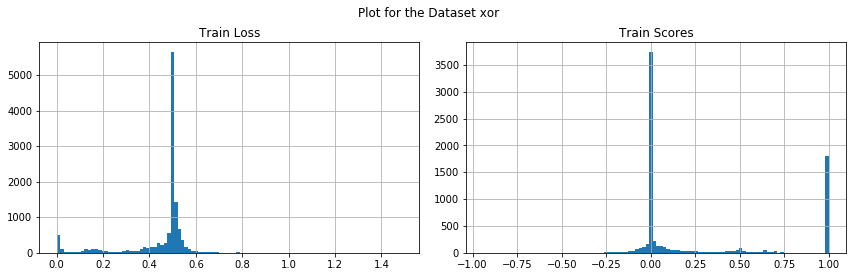

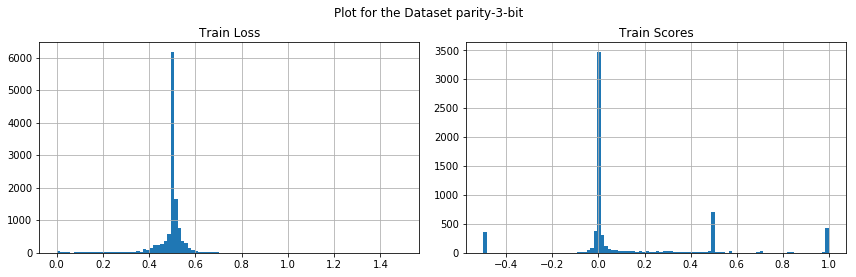

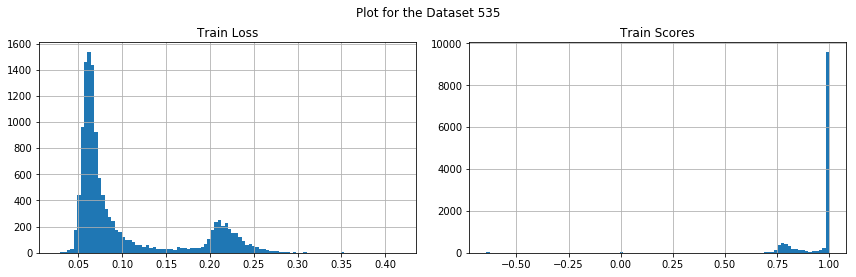

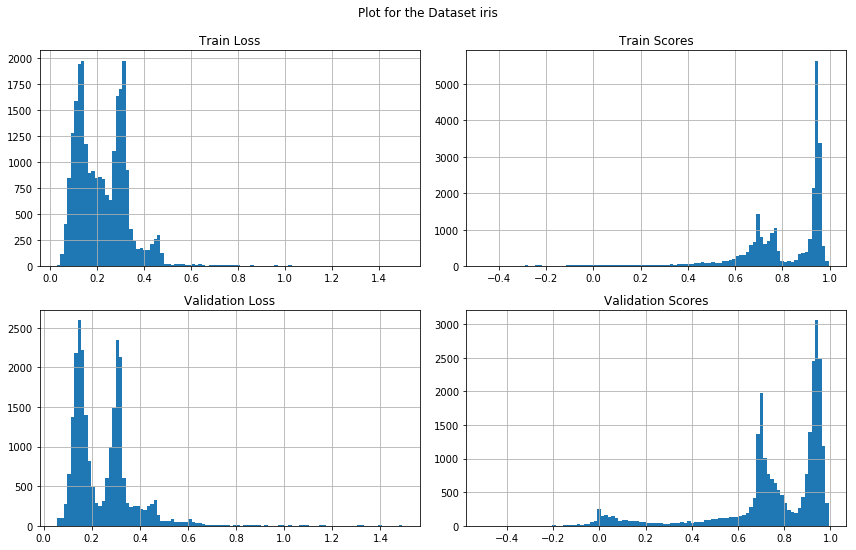

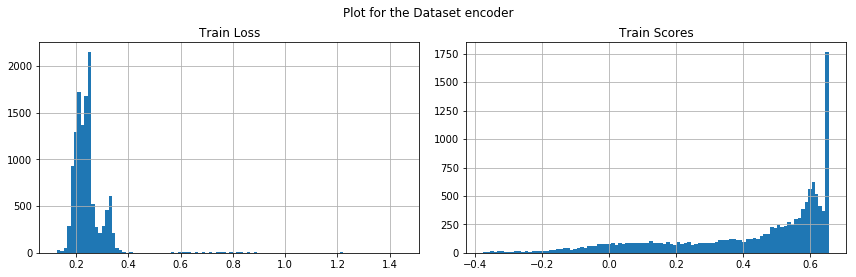

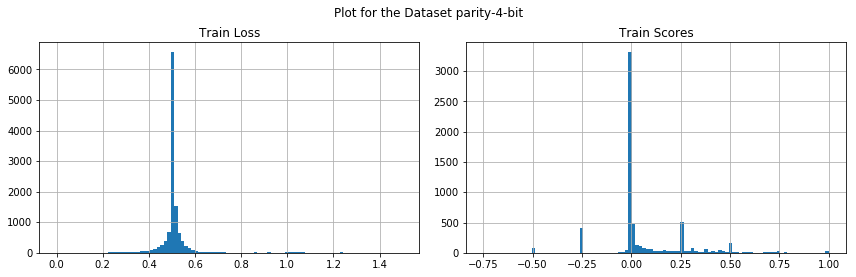

In [5]:
print('Metrics for Regression Tasks by Dataset')

for dataset in datasets:
    plot(df[using_regression & (df['dataset'] == dataset)], thresholds=(1.5, -1, 1.5, -1))

## Analysis of Regression Models Without ReLU Activation
- Some anomalous data points have been removed, however the data seems to tell the same story as before.

Metrics for Regression Tasks Not Using ReLU by Dataset


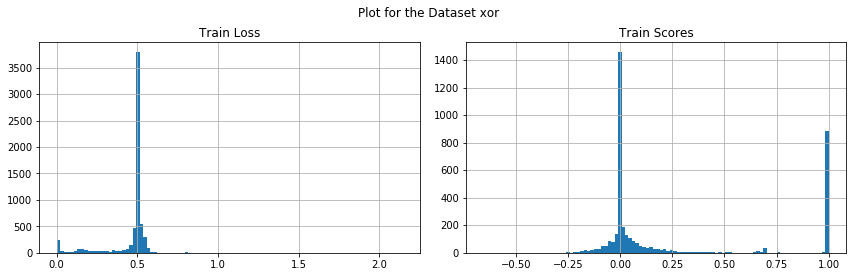

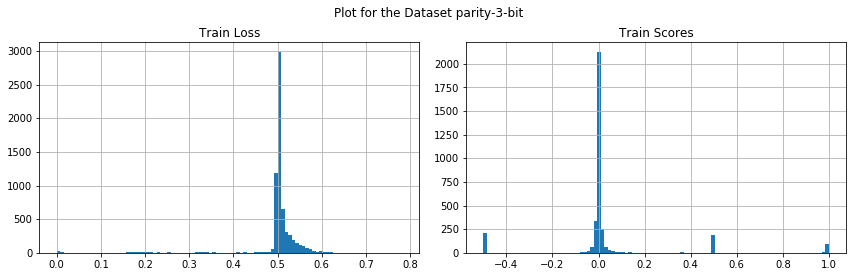

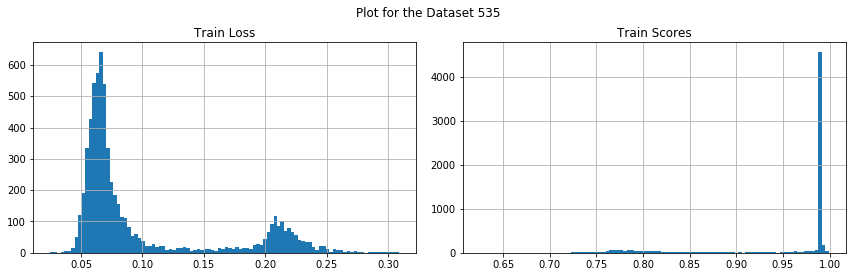

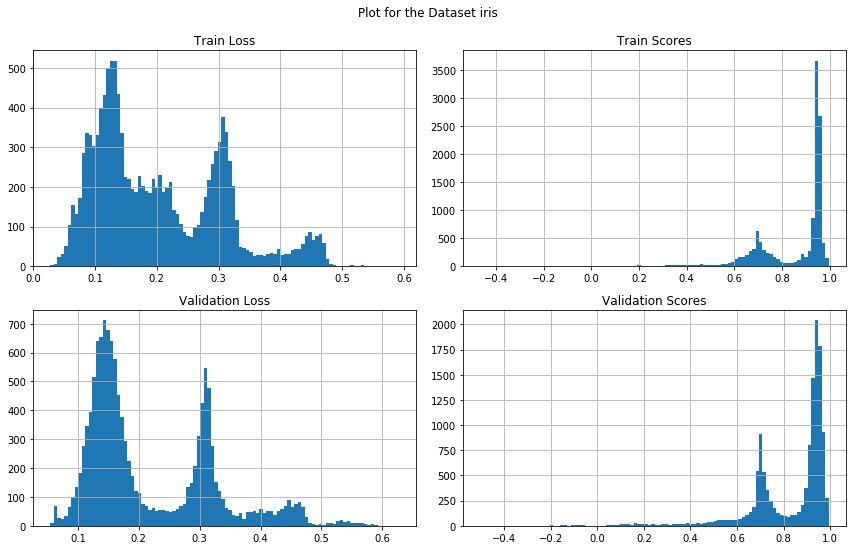

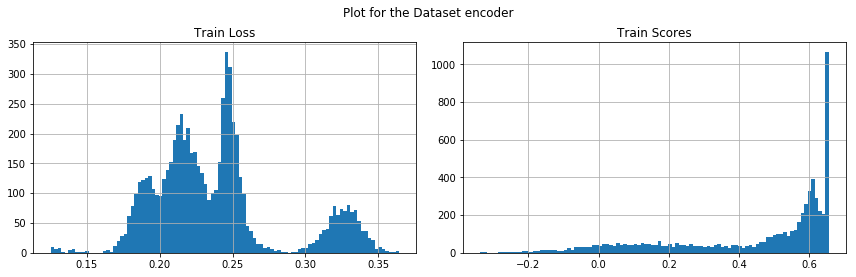

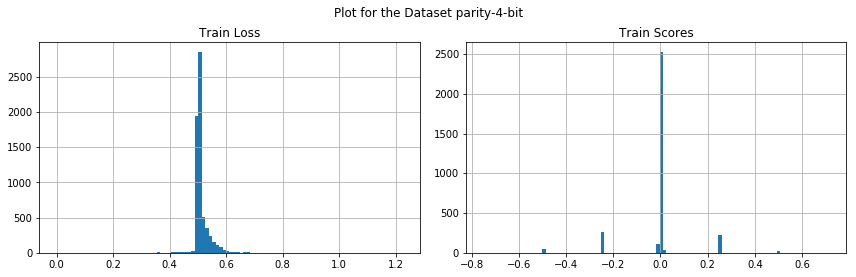

In [6]:
print('Metrics for Regression Tasks Not Using ReLU by Dataset')

for dataset in datasets:
    plot(df[~using_relu & using_regression & (df['dataset'] == dataset)], thresholds=(2.5, -1, 2.5, -1))

## Analysis of Regression Models by Dataset
- These plots seem to confirm that the MLP models struggled with the XOR, parity-3-bit, and the parity-4-bit datasets. However, the reasons why they struggled are still not clear.

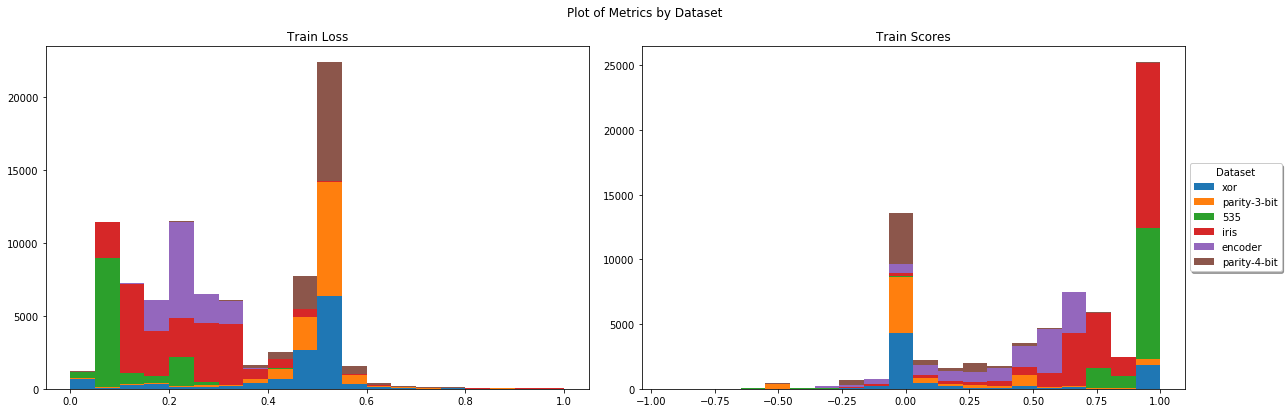

In [7]:
plot_hue(df[using_regression], hue='dataset', bins=20, stacked=True, thresholds=(1.0, -1, 2.5, -1))

## Analysis of Regression Models by Activation Function
- Interestlingly enough, it seems my hypothesis about the ReLU being the main suspect for the high fail rates of the models is unfounded, and incorrect. Most cases, by a small margin, where the models failed to converge seems to be where the sigmoid activation was used.
- It seems that activation function alone is not related to the high fail rates.

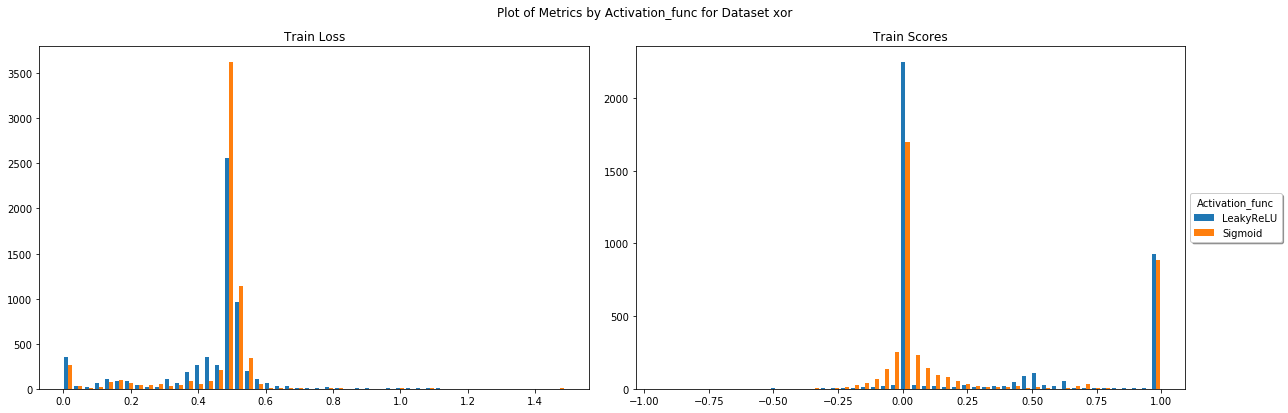

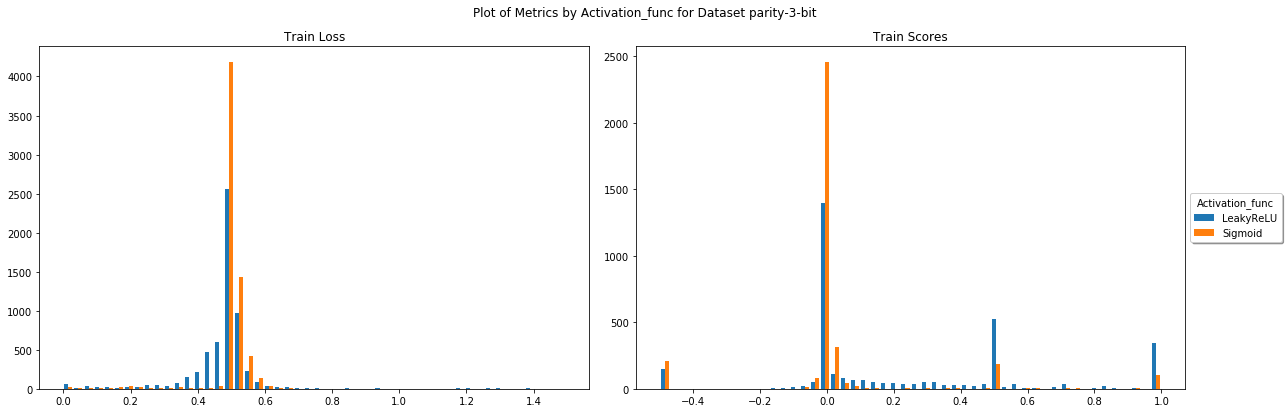

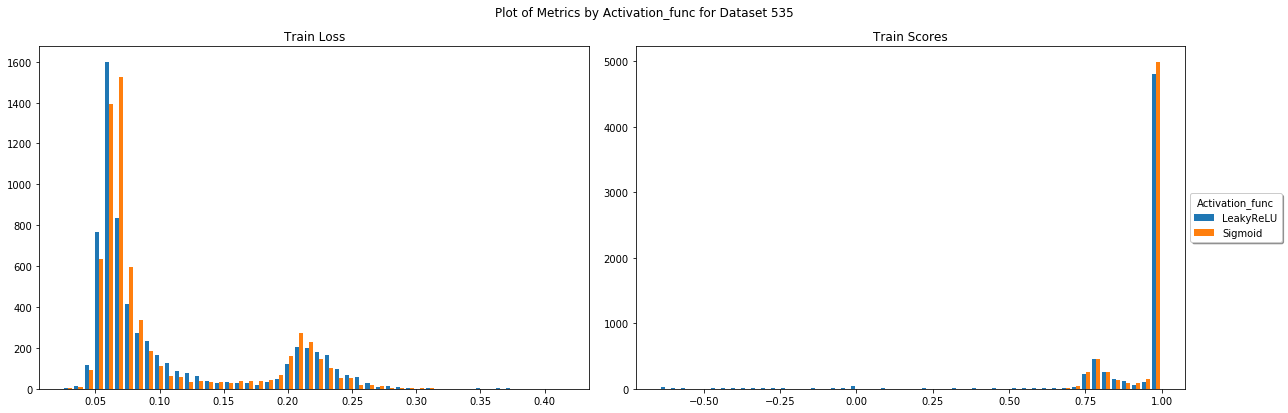

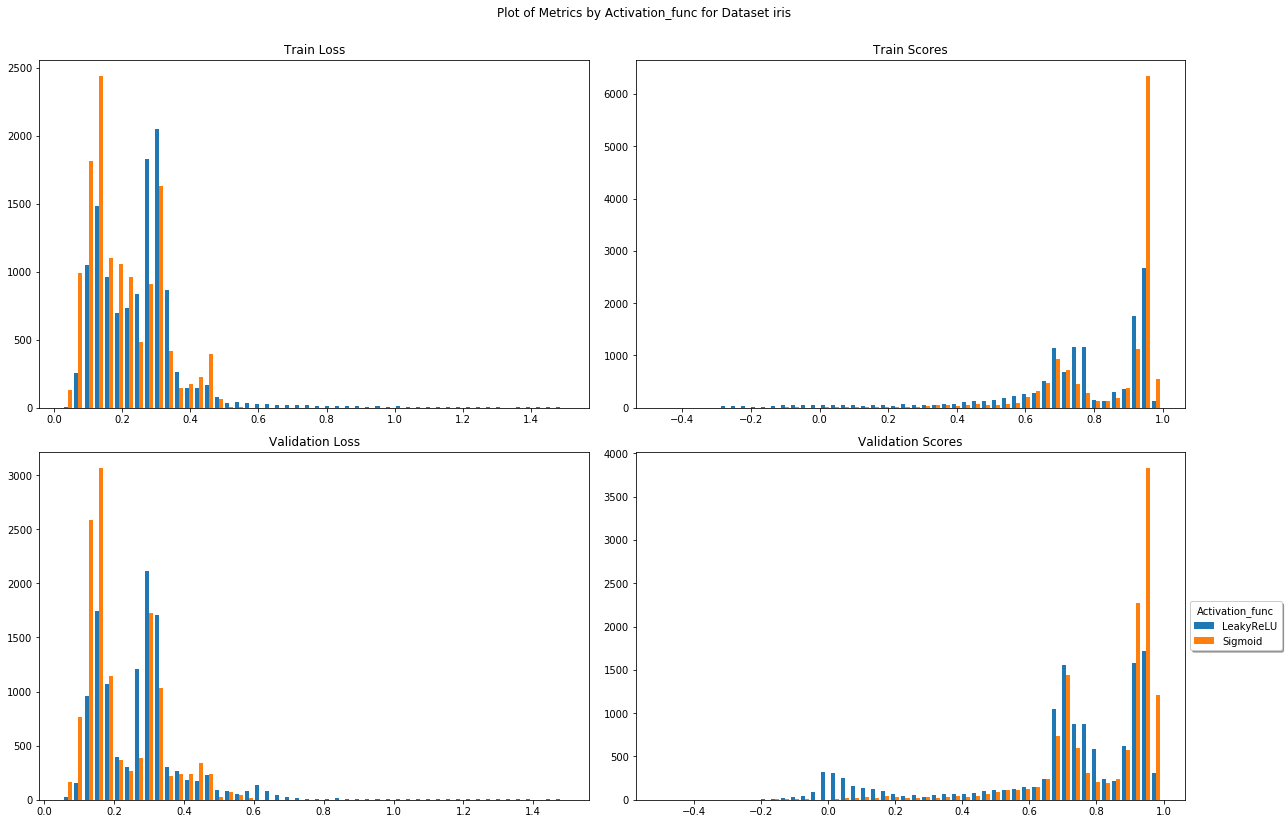

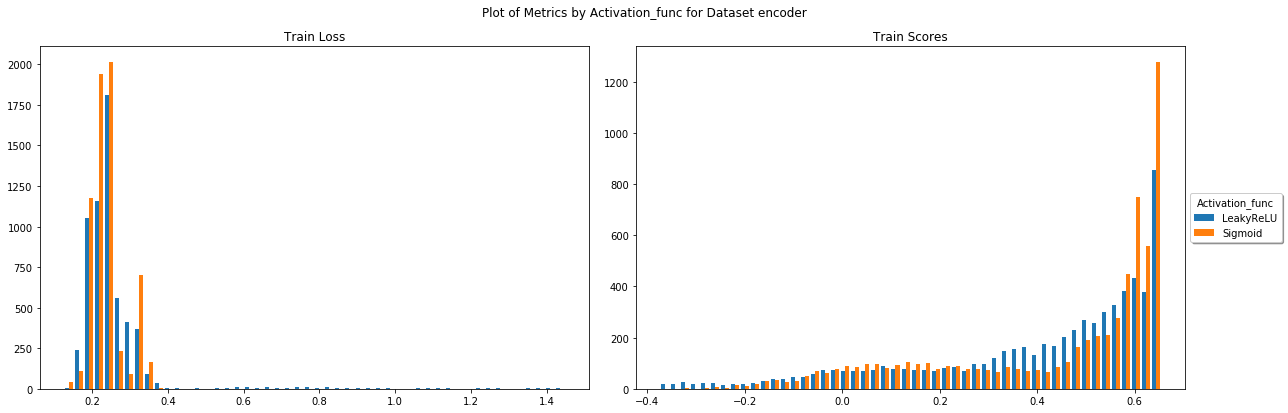

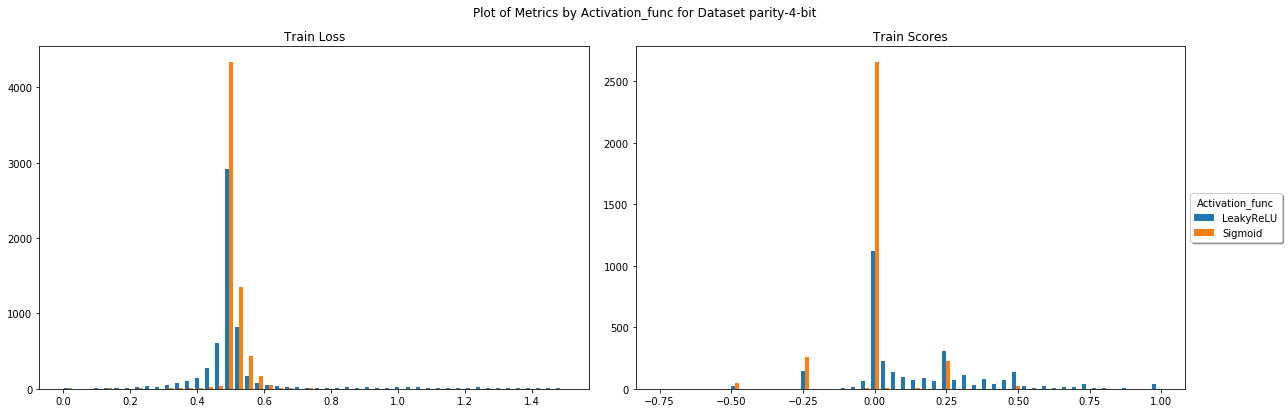

In [8]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='activation_func', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Batch Size
- The first thing that you may notice is that the training scores for $batch\_size=1$ are missing. 
  I had thought that by adding a small value $\epsilon$ to the denominator of the PCC I would have got zero, or near zero, training scores occaisionally.
- It would seem that the configurations with $batch\_size=1$ have conveniently omitted invalid scores :)
- However, my other hypothesis for the cause of the high fail rates is now proven to be wrong. The plot thickens...

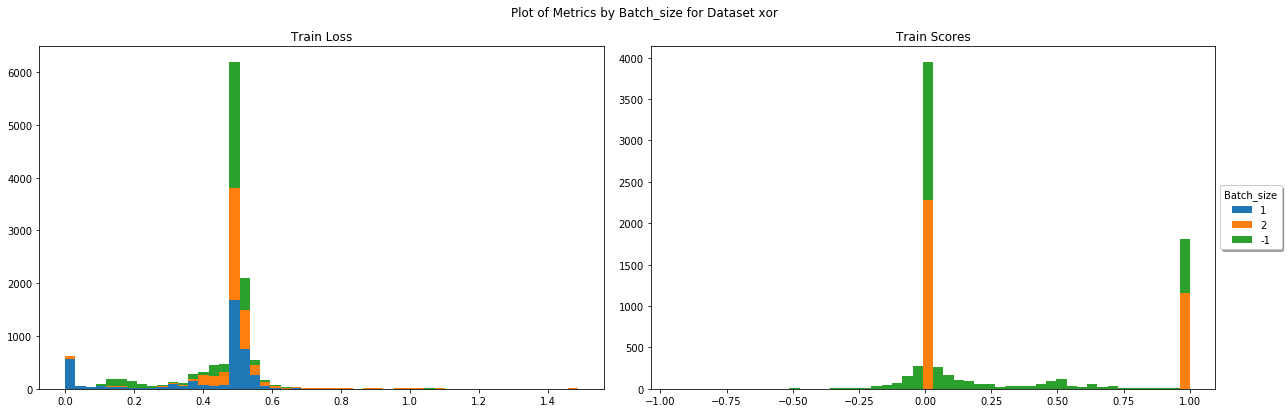

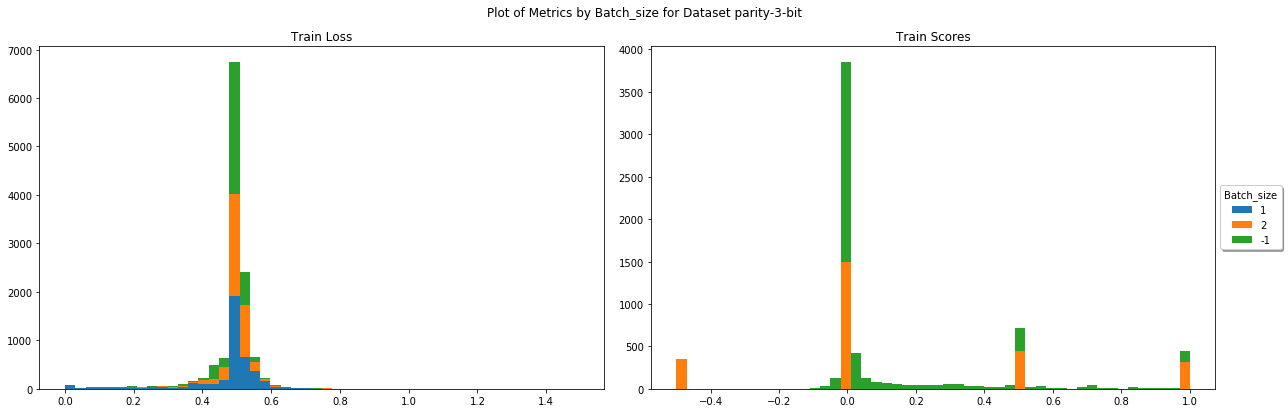

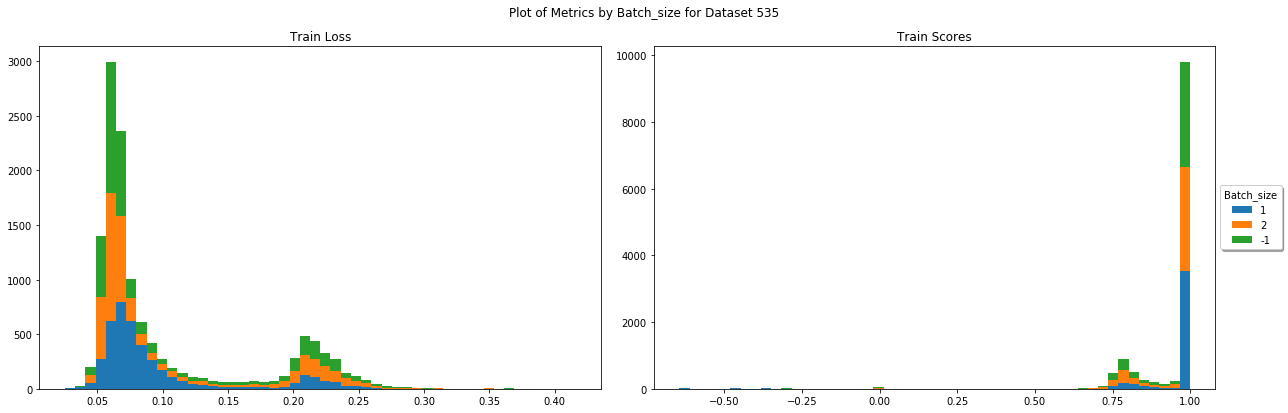

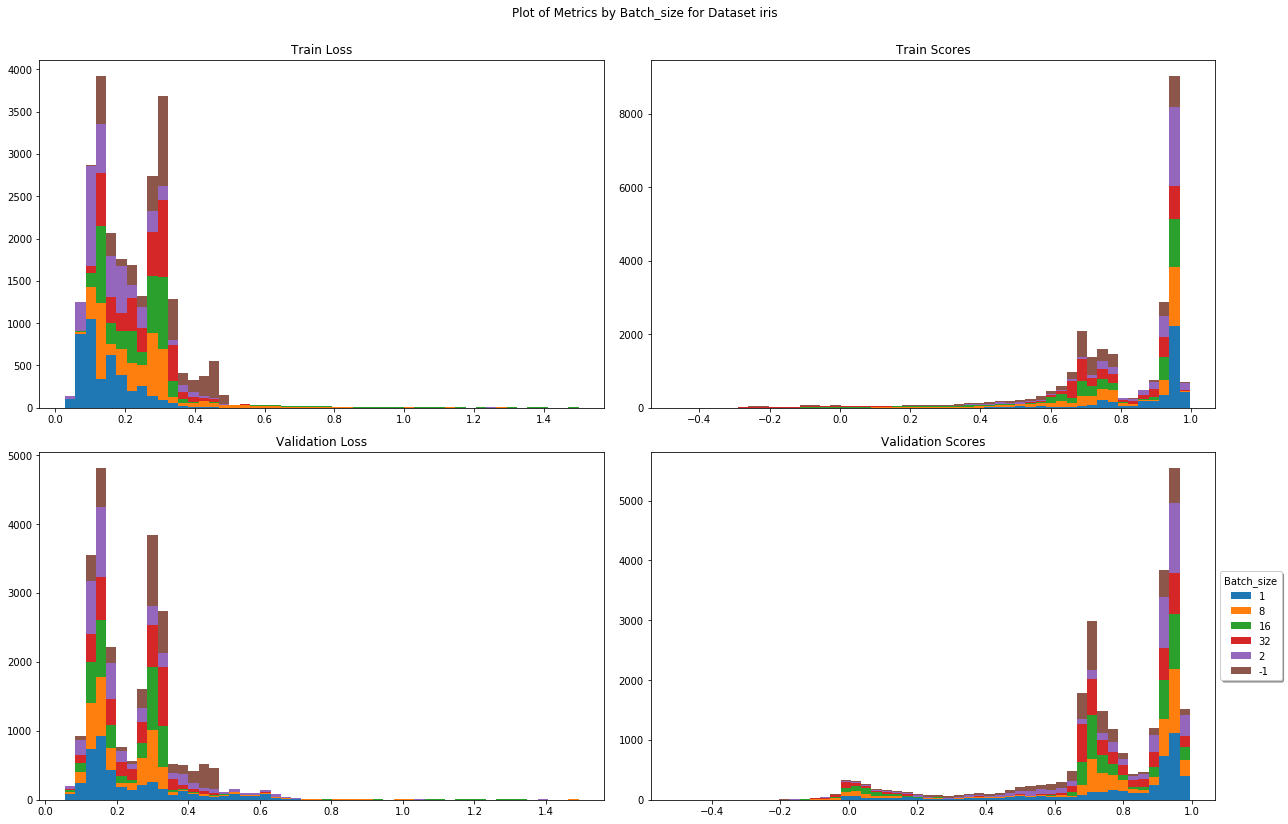

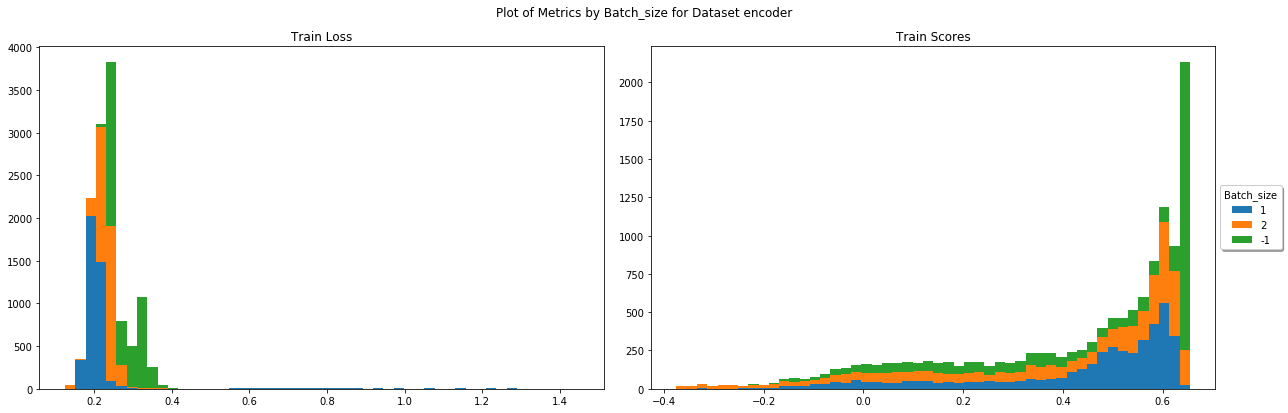

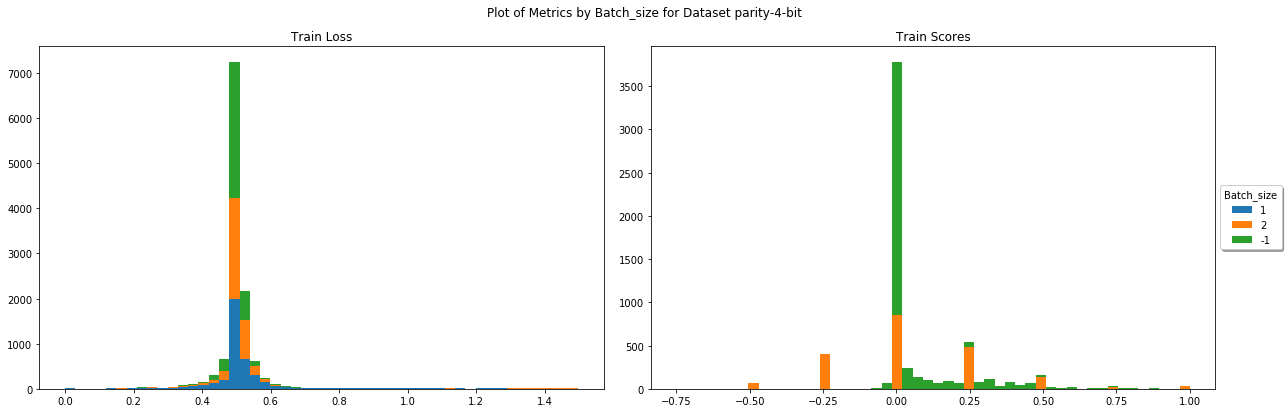

In [9]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='batch_size', stacked=True, thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Gaussian Noise
- Again, no clear indication of what is causing the high fail rates. Perhaps it is a specific combination of hyperparameters that had a high fail rate?
- It seems that adding noise to the inputs benefitted the models trained on the iris dataset the most. This seems
  reasonable since the other problems had binary input/output spaces.

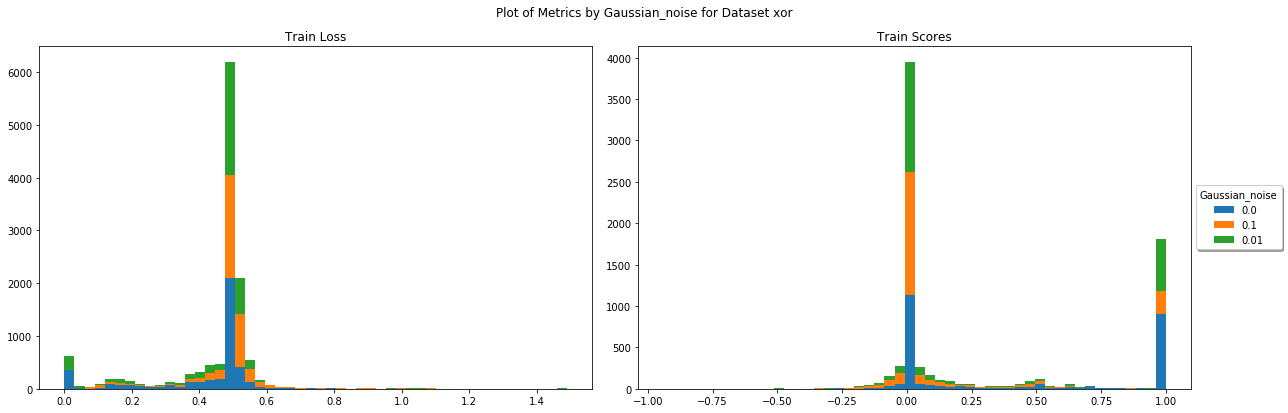

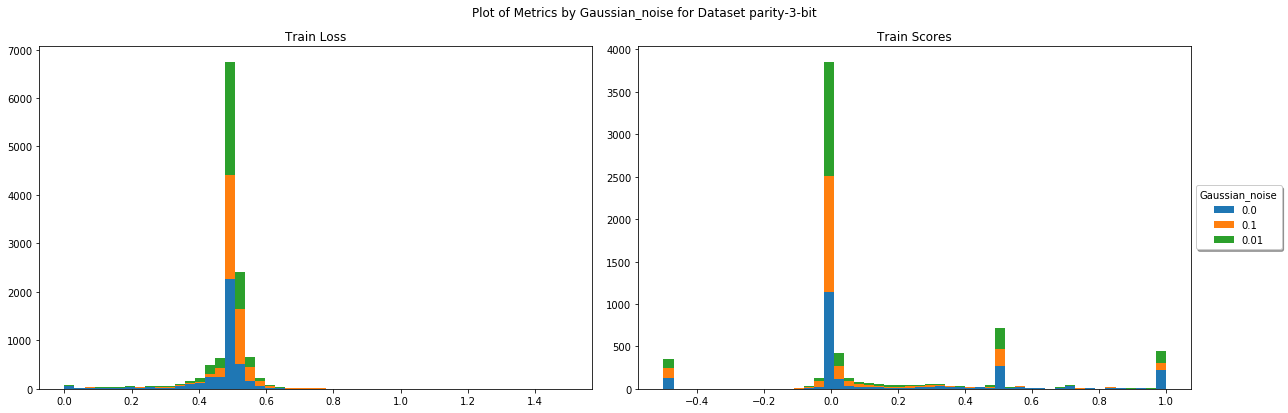

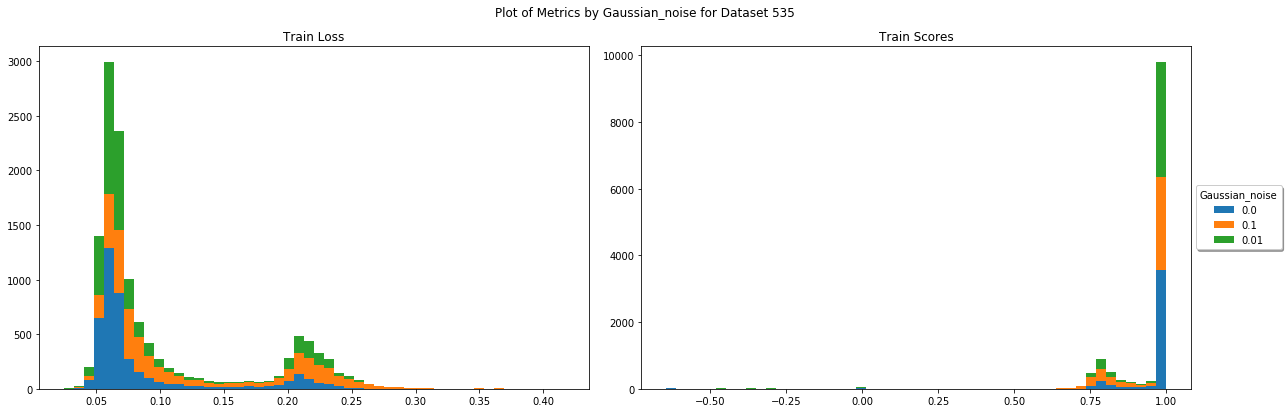

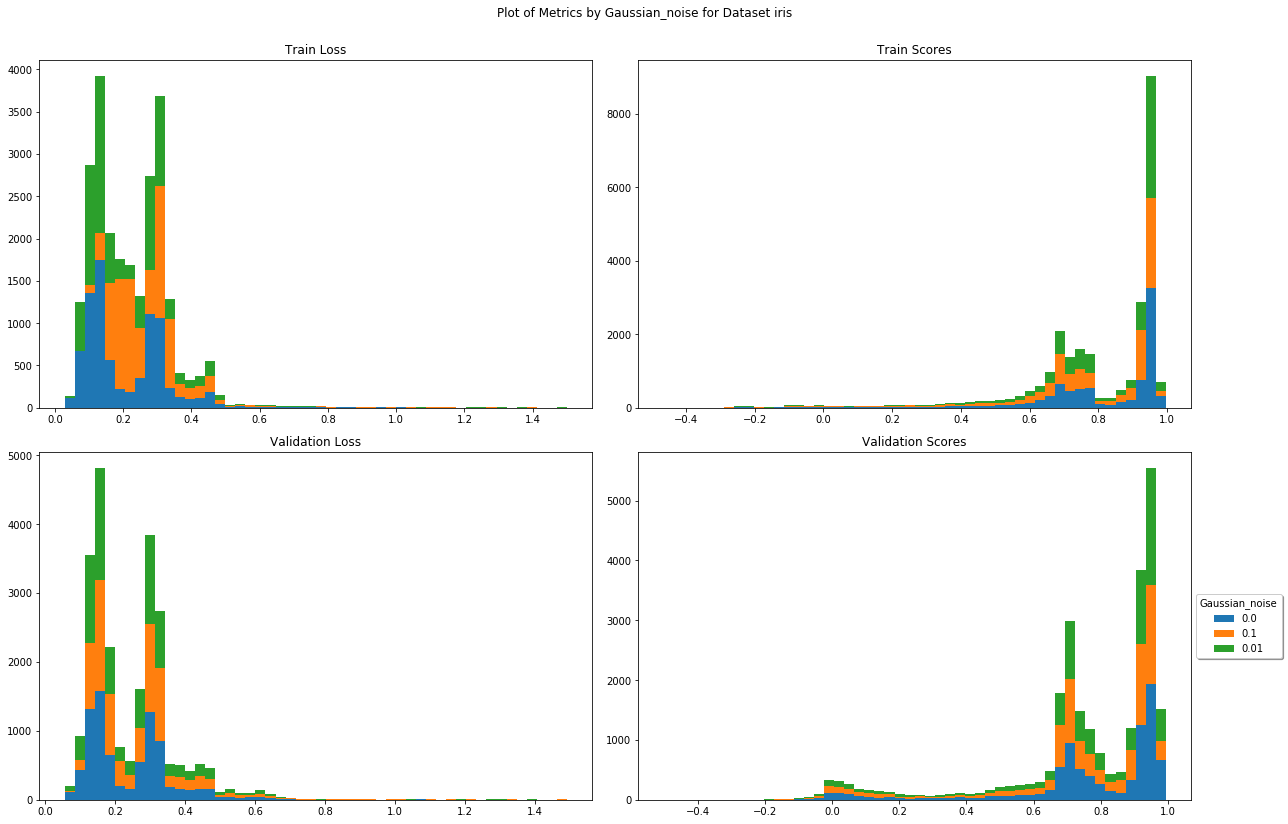

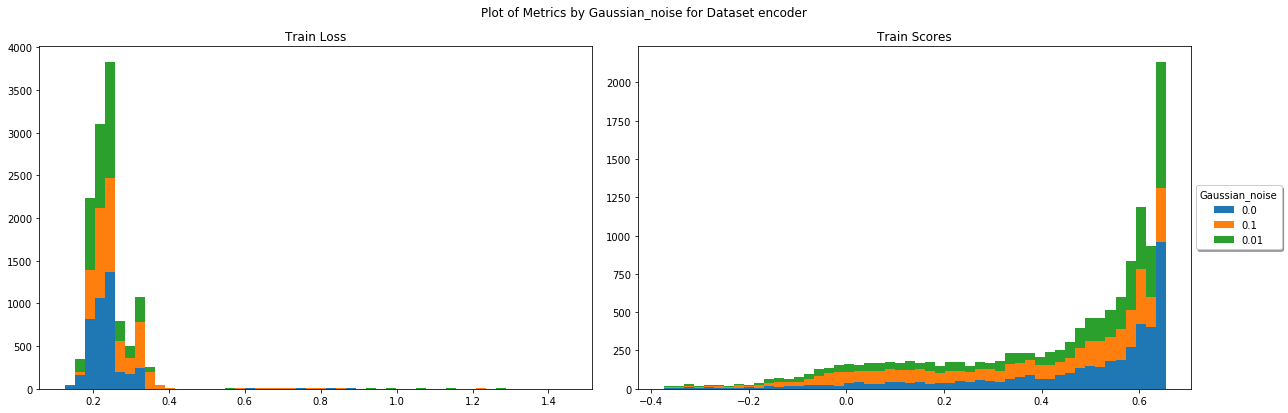

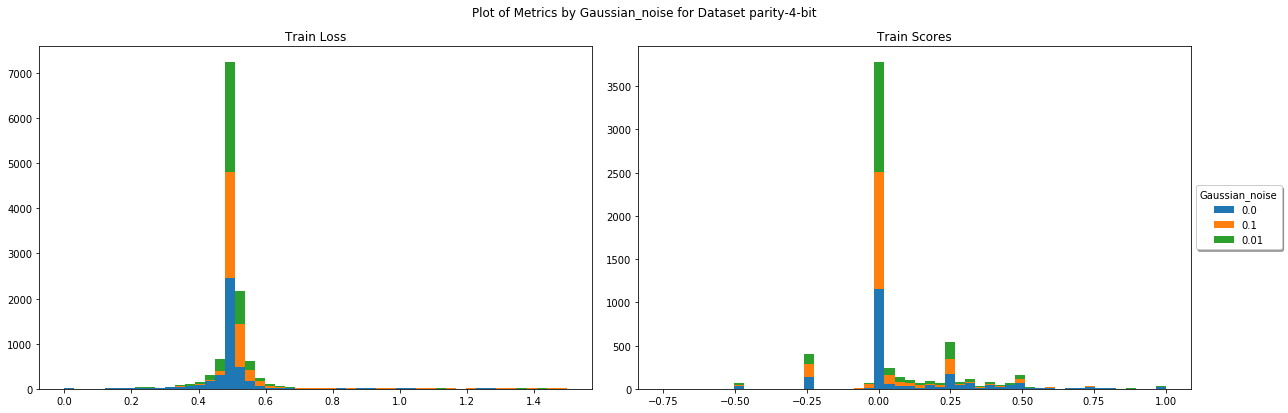

In [10]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='gaussian_noise', thresholds=(1.5, -1, 1.5, -1),
            stacked=True)
    plt.show()

## Analysis of Regression Models by Learning Rate
- Same story as above.
- It seems that a learning rate of 0.01 performs the best.

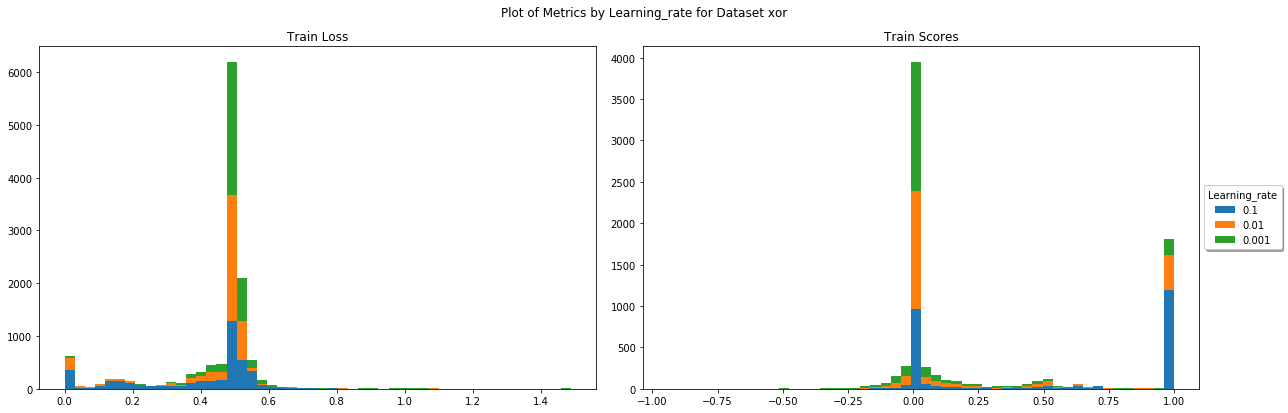

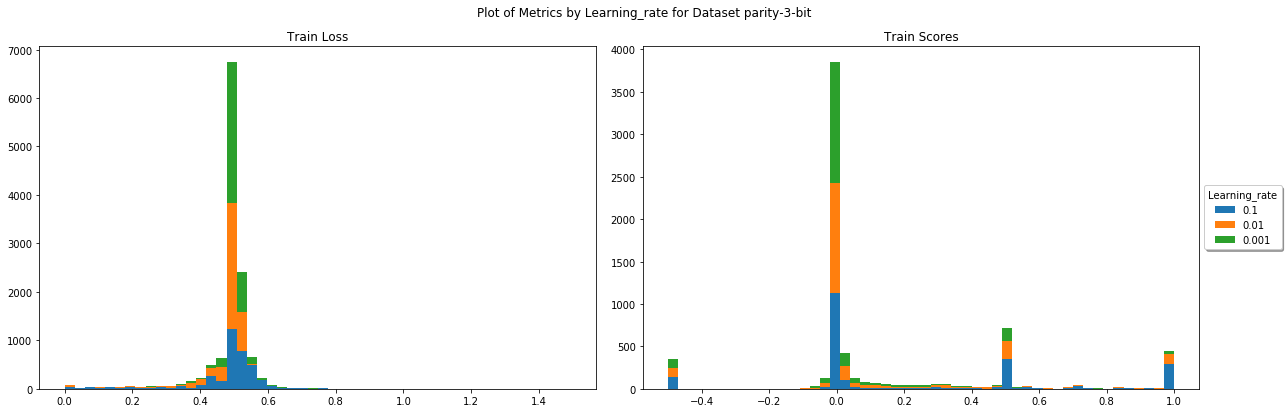

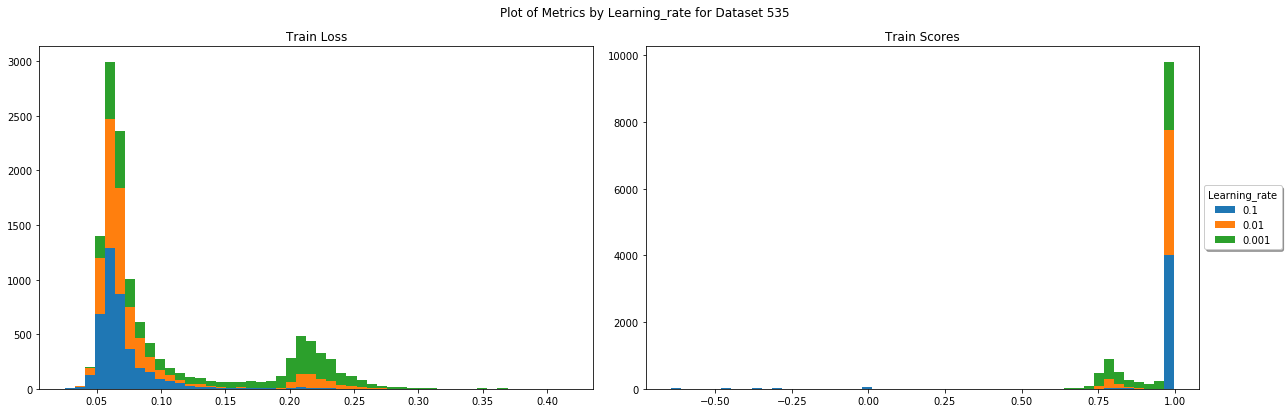

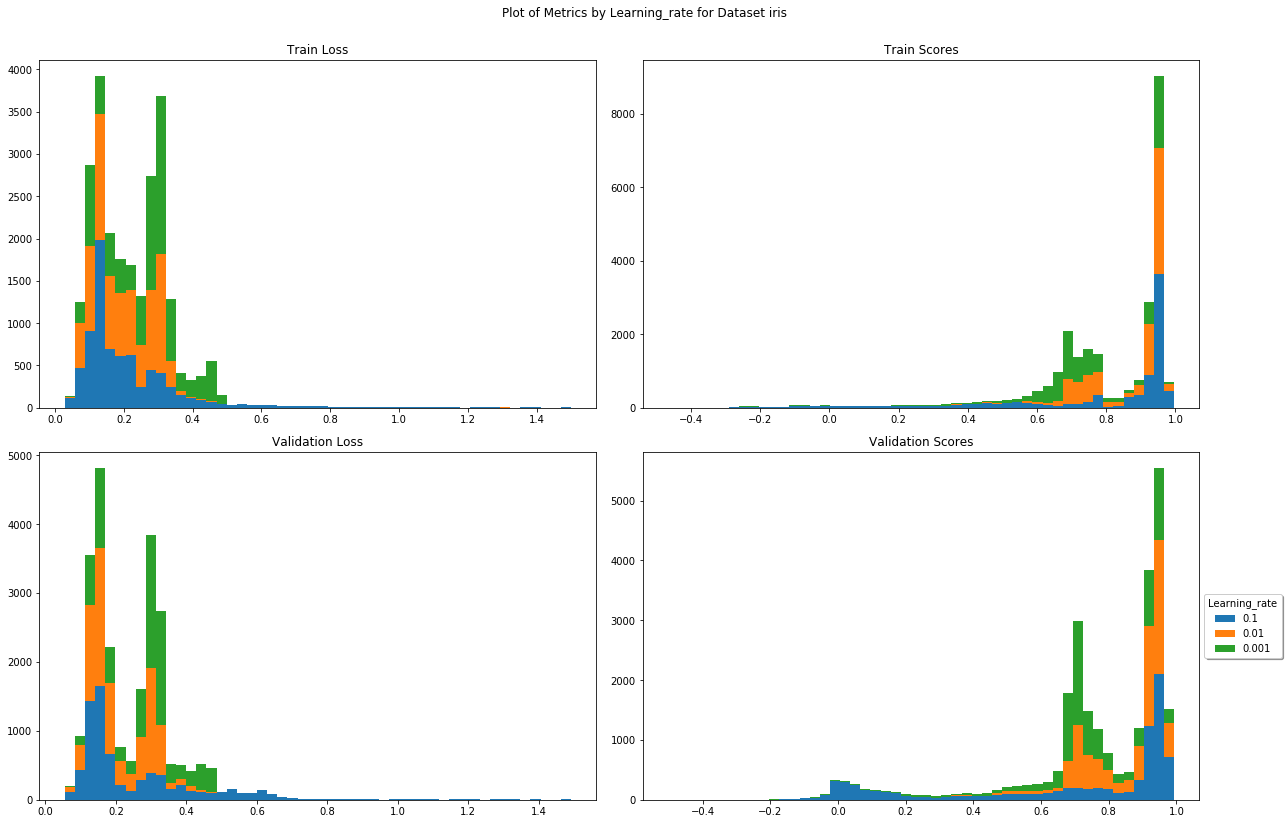

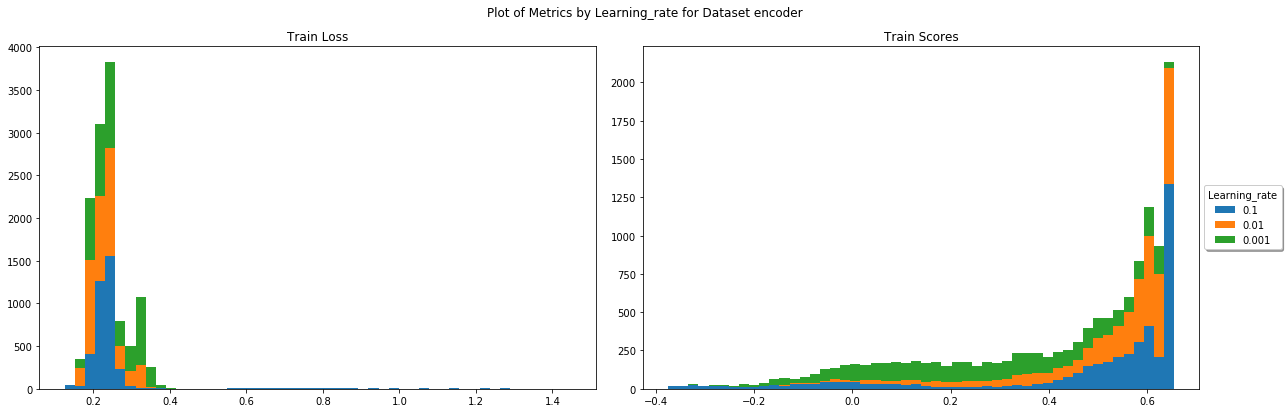

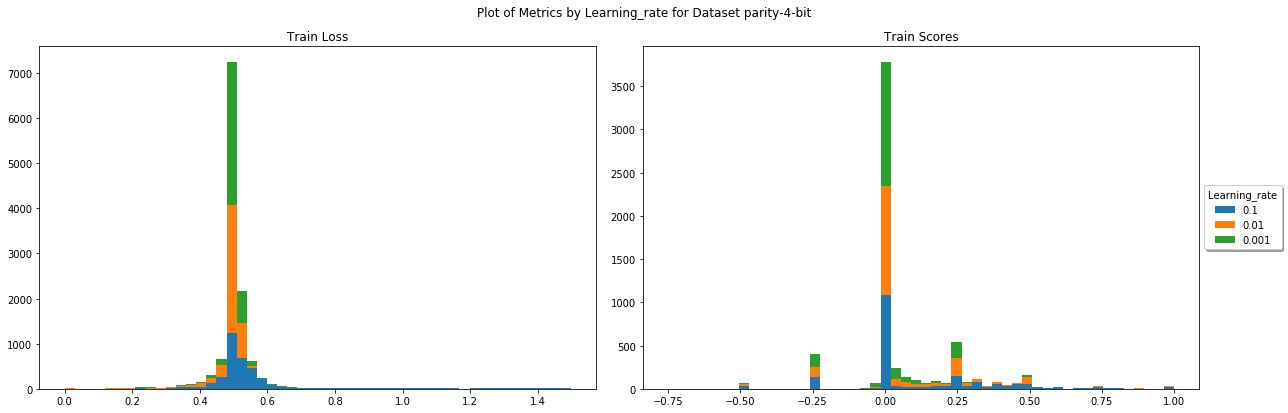

In [11]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='learning_rate', thresholds=(1.5, -1, 1.5, -1),
            stacked=True)
    plt.show()

## Analysis of Regression Models by Momentum
- Same story as above.

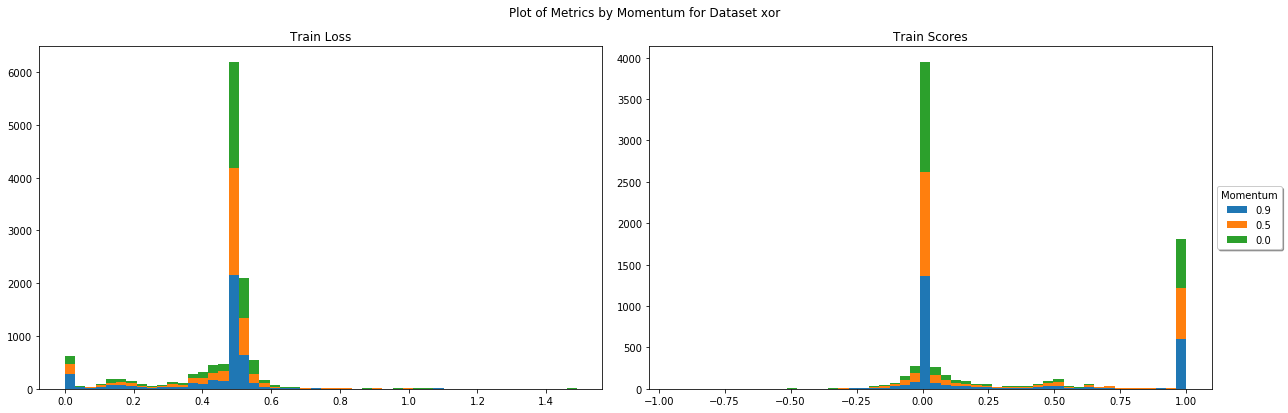

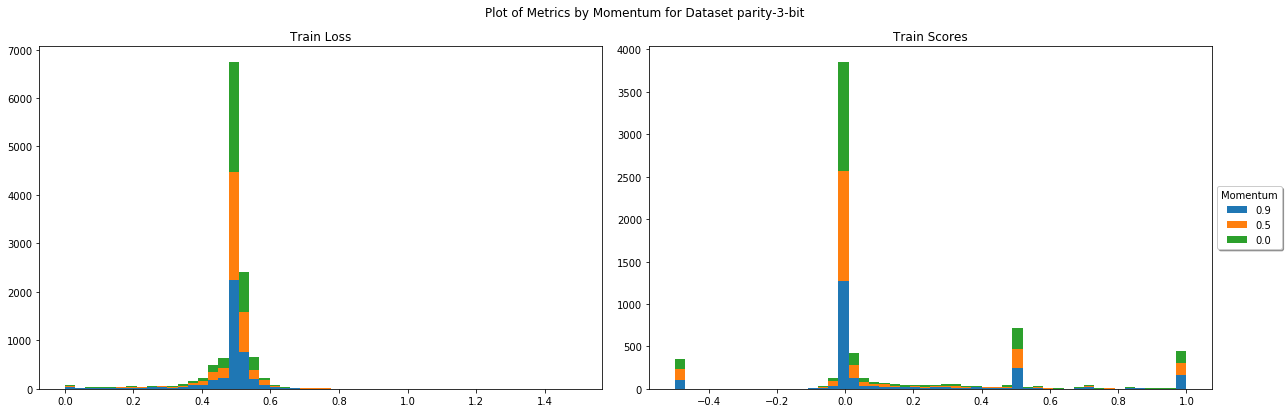

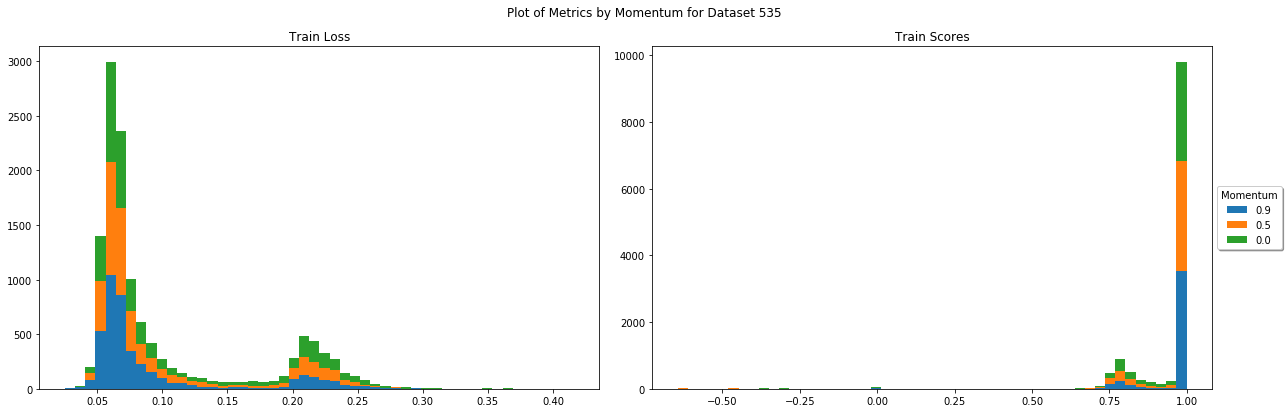

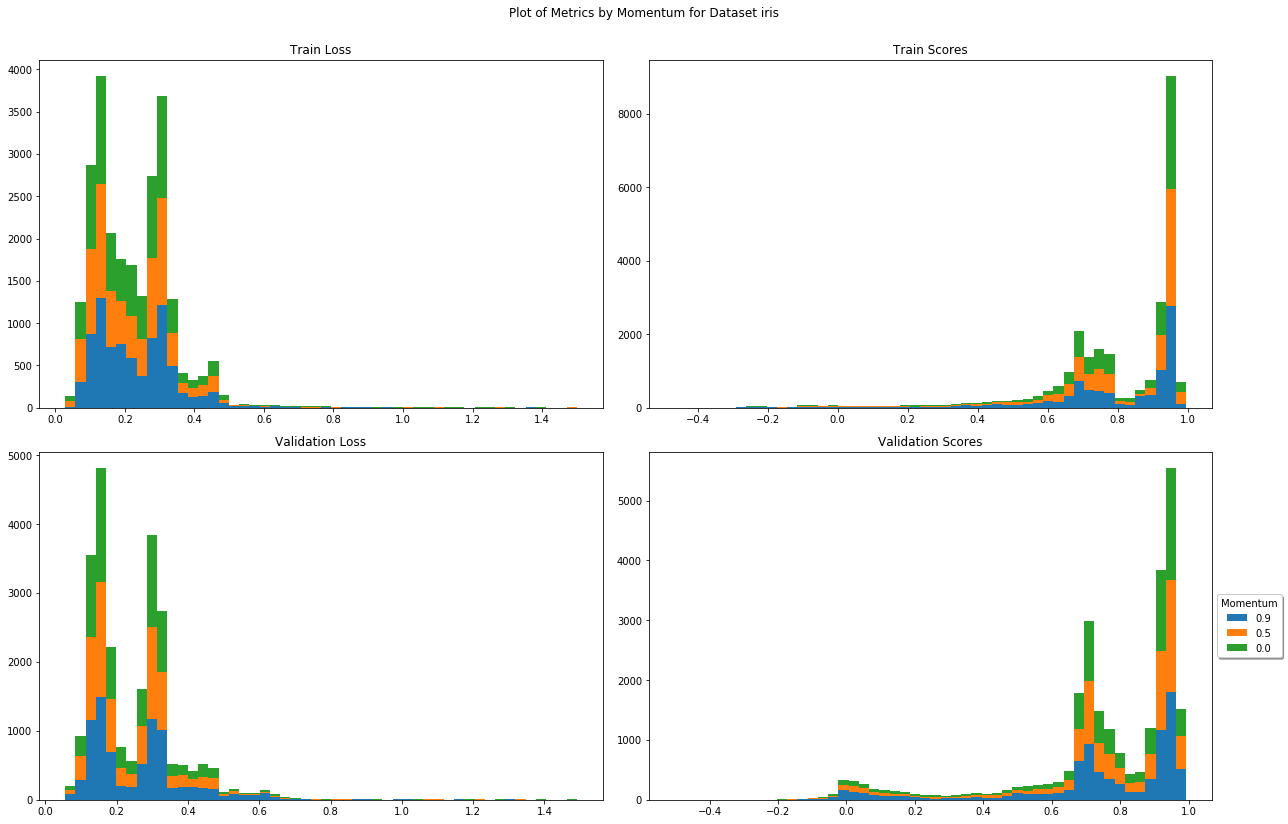

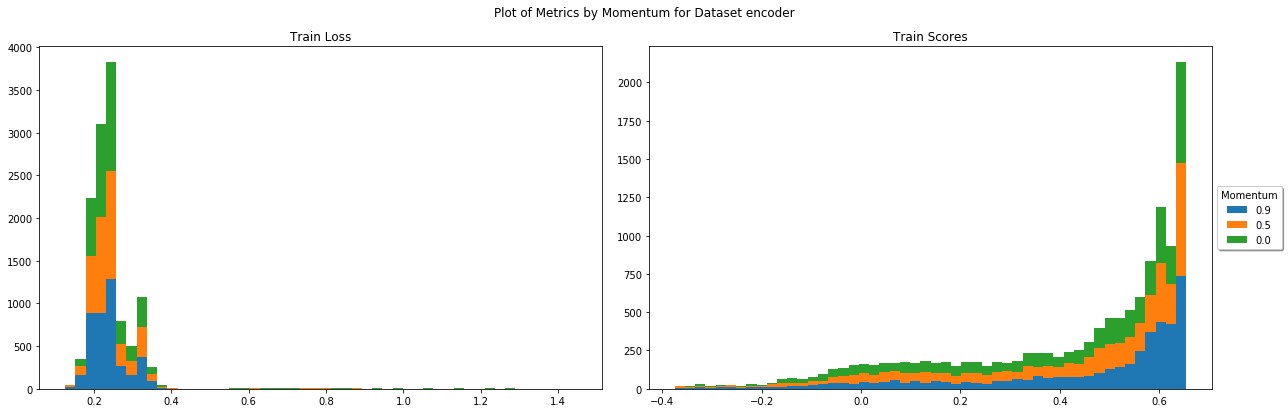

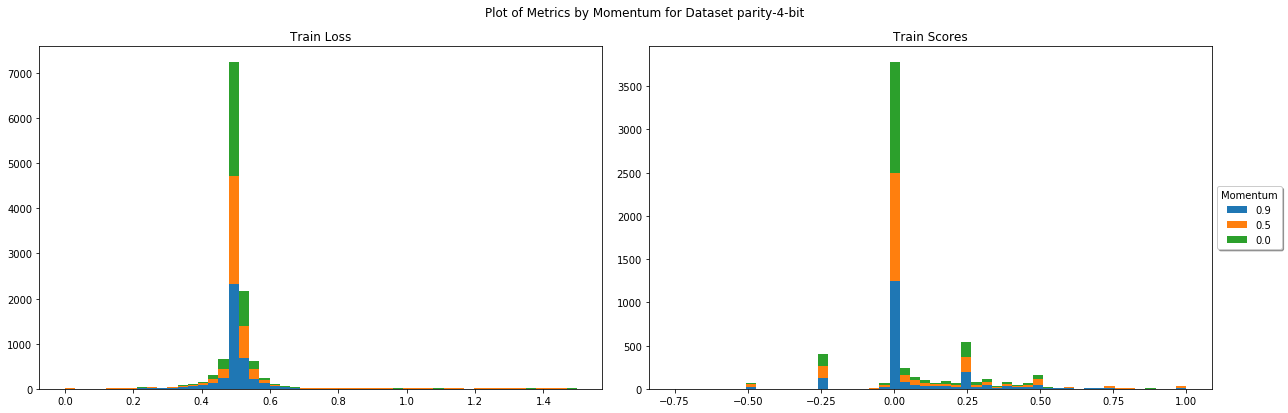

In [12]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='momentum', thresholds=(1.5, -1, 1.5, -1),
            stacked=True)
    plt.show()

## Analysis of Regression Models by Batch Shuffling
- Again, same story as above. I think that this confirms that there must be some combination of hyperparameters that is causing the spike of training scores of zero.

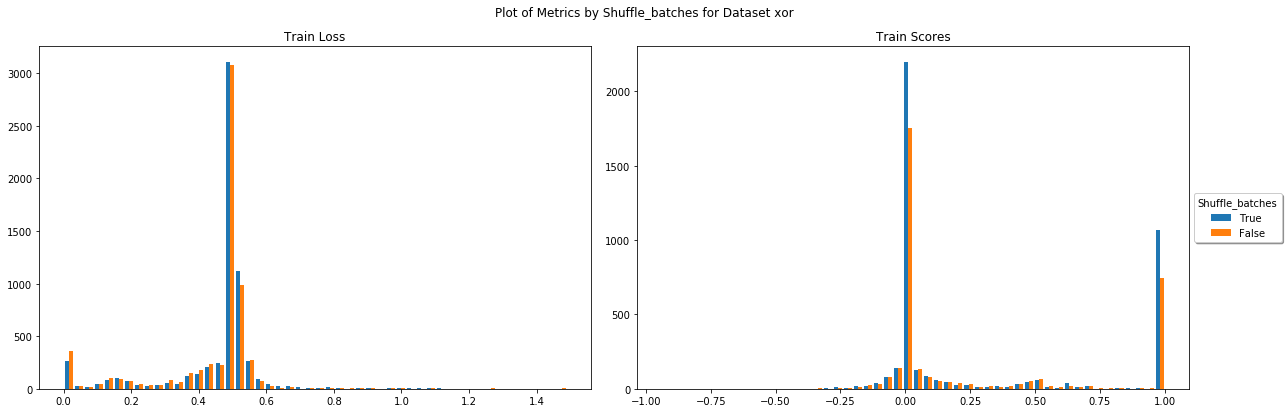

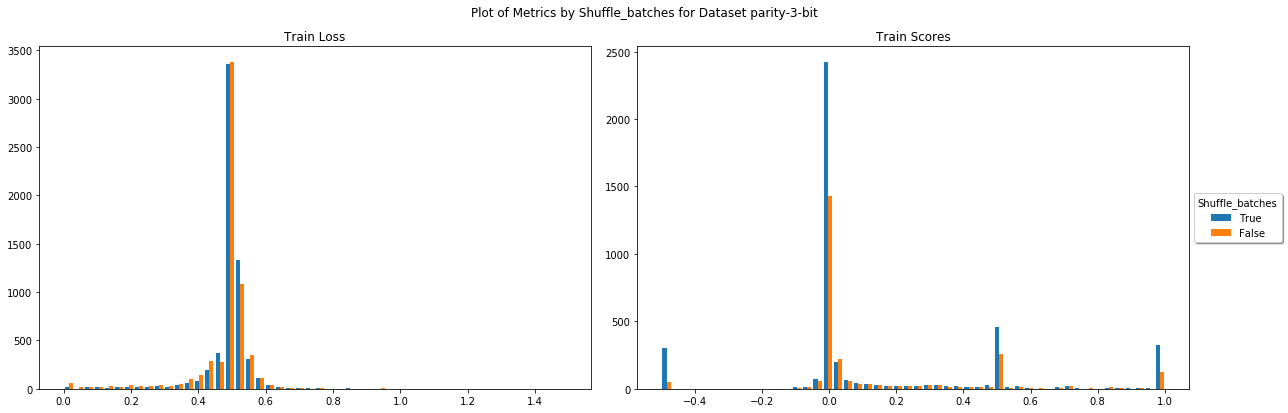

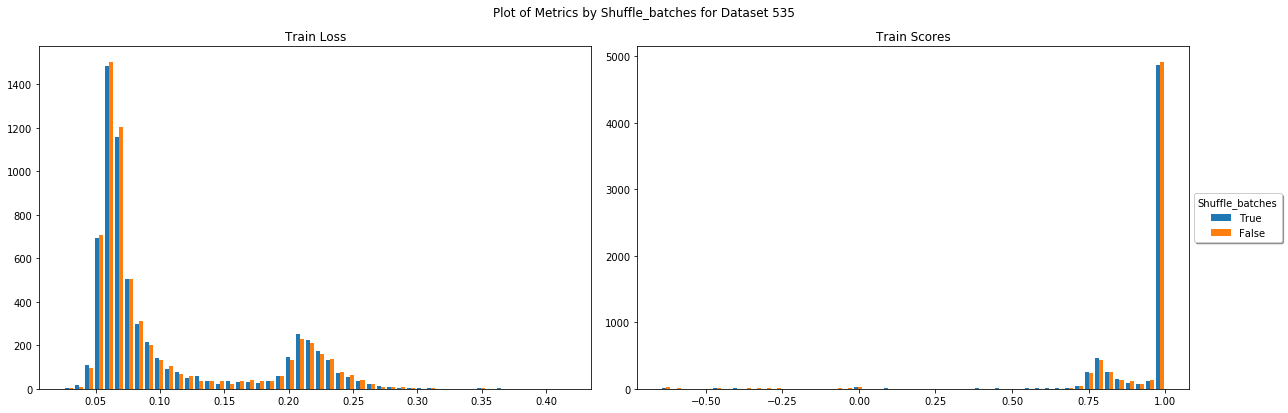

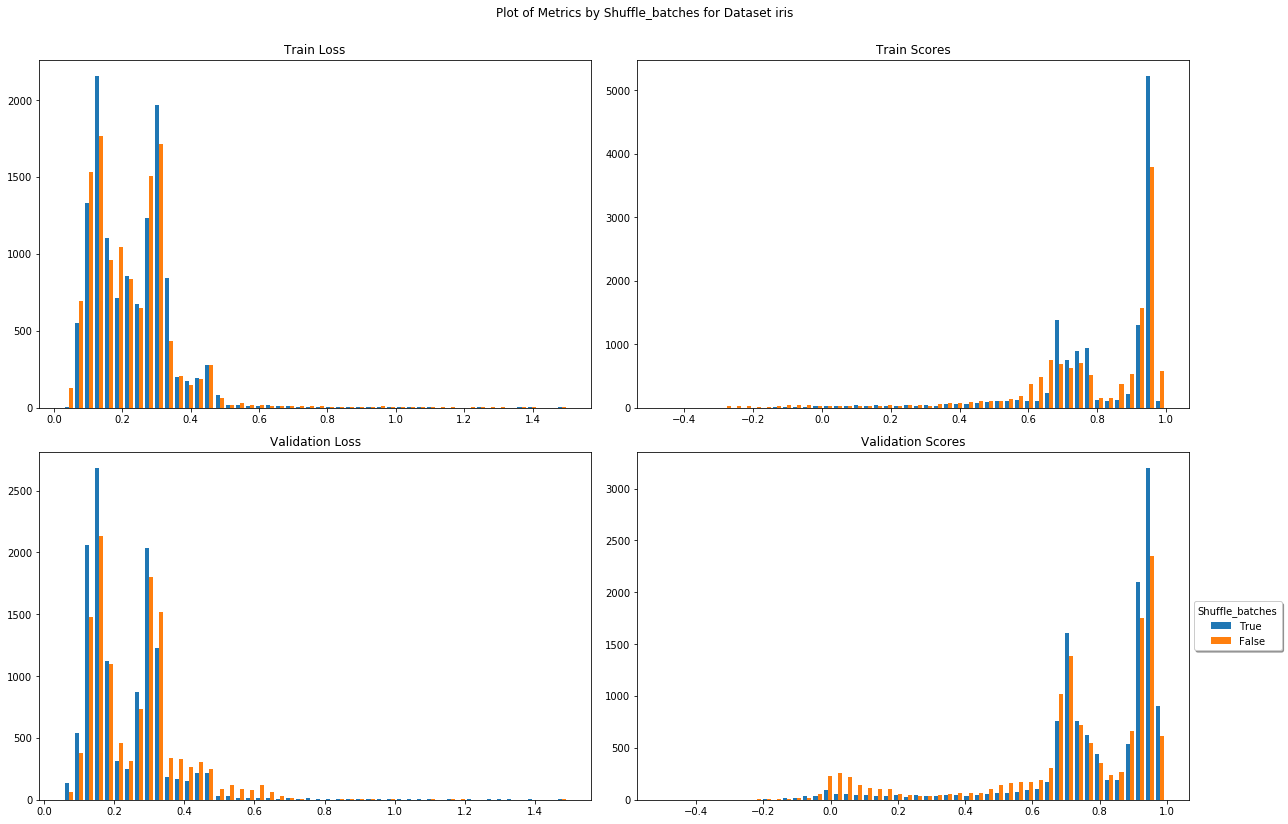

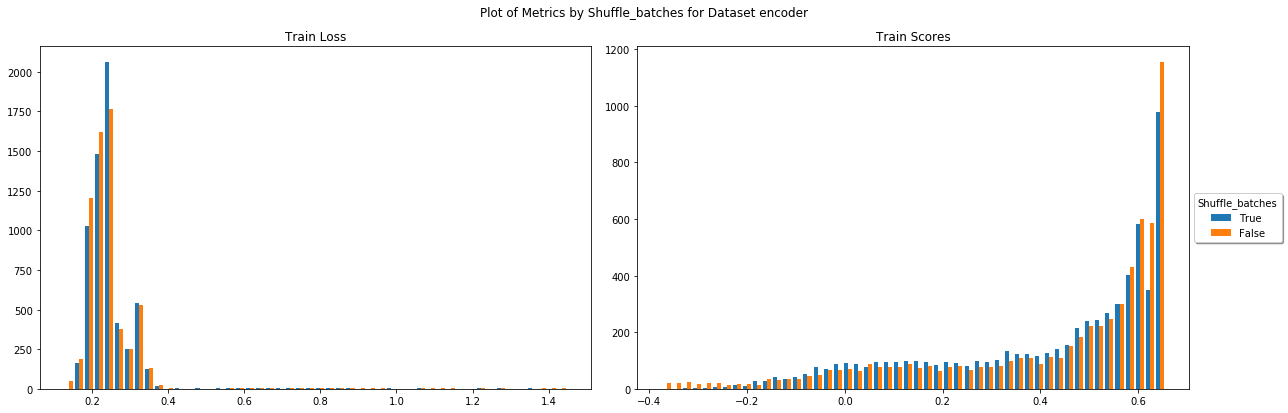

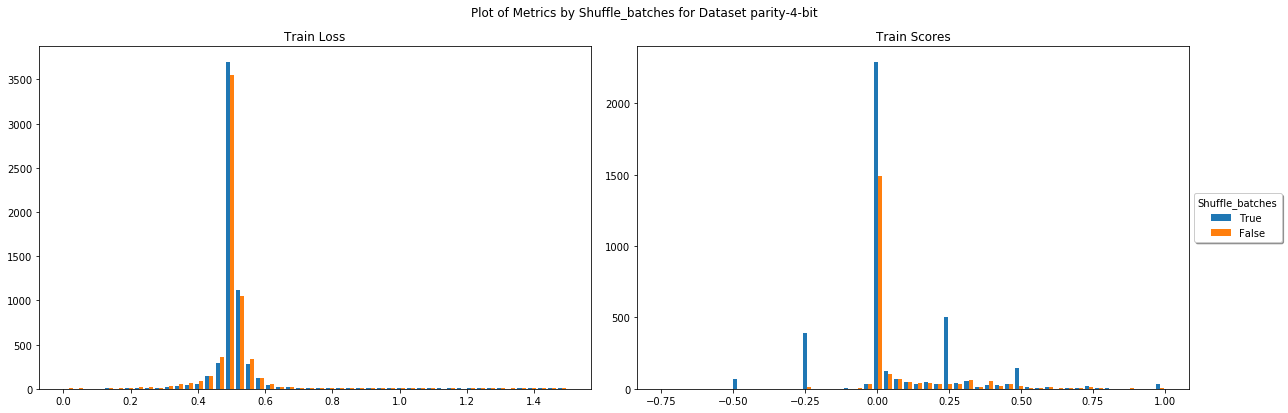

In [13]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='shuffle_batches', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Are There High Failure Rates in Classification Models?
- Not really, however the peaks have shifted from 0.0 to 0.5 (still right in the middle though). However, it sill
  follows the same pattern. Perhaps it is something intrinsic to the datasets and/or how these datasets were tested?  
- It would seem that in both regression and classification models, there are a number of instances that got stuck in a sort of limbo. In the case of the regression models, they would often get stuck at 0.5 loss which would indicate that the outputs are getting stuck somewhere between 0 and 1 for the tasks with a single binary output space. Simlarly, in the case of classification models would often get stuck at 0.5 accuracy.

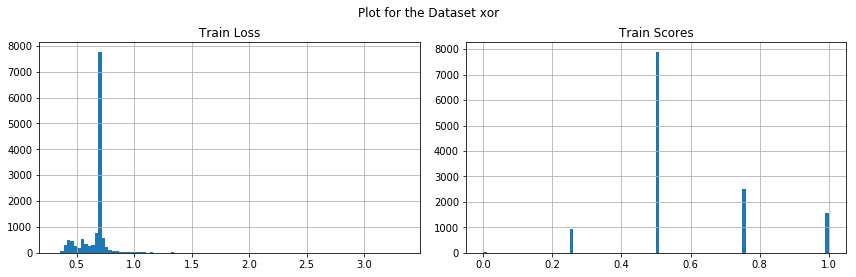

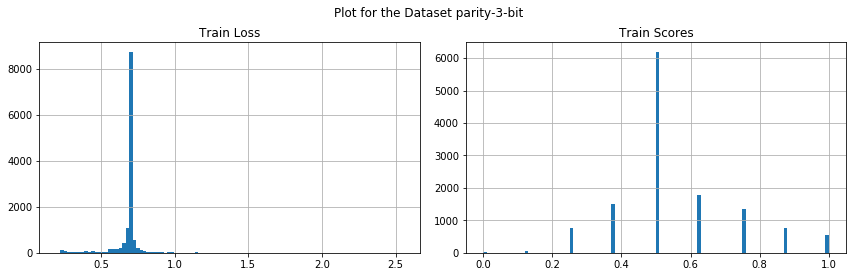

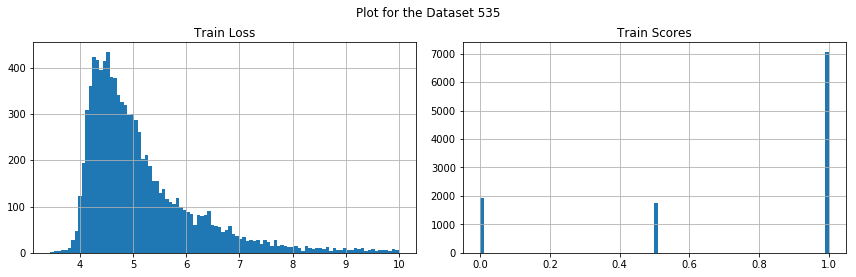

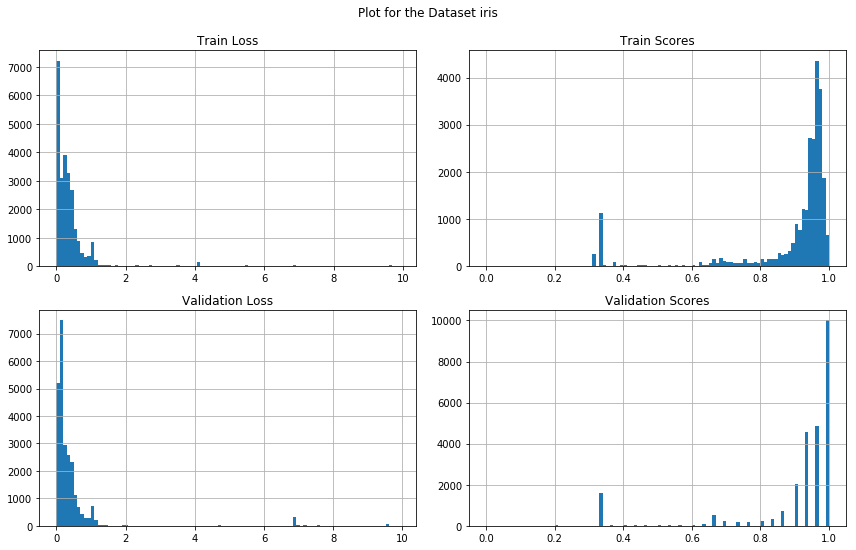

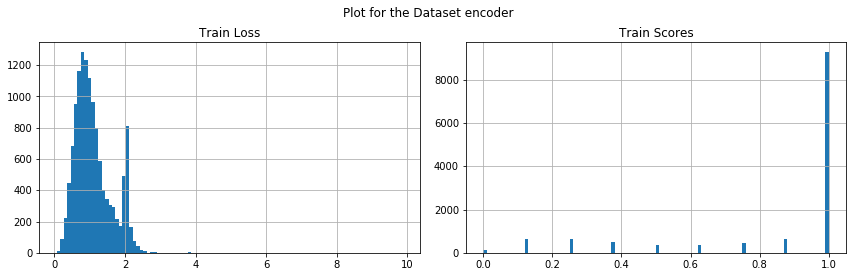

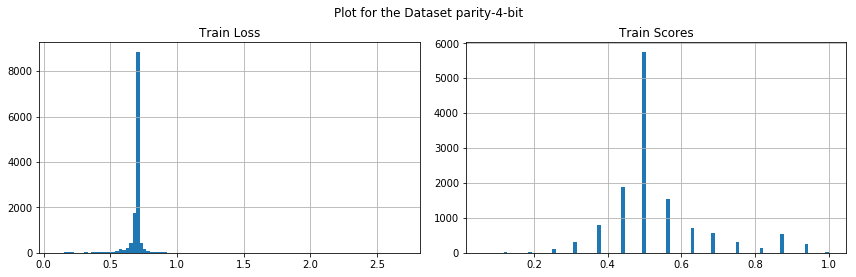

In [14]:
for dataset in datasets:
    plot(df[~using_regression & (df['dataset'] == dataset)], 
         thresholds=(10, -1, 10, -1))
    plt.show()

## Analysis of Failure Rate
Here we define failure rate as either a regression model getting stuck on $0.5 \pm 0.01$ RMSE loss or a classification model getting stuck at $0.5 \pm 0.01$ accuracy.

- I thought it may have been the early stopping which would be prematurely stopping training and preventing the models from converging, but a quick experiment on the XOR dataset  showed about 56% instances failed to converge after 10000 epochs ($n=30$). So perhaps this is something intrinsic to the datasets after all. This seems to agree with what we observe in the plots below and above. A similar experiment was done in [Neuromorphic Computing for Cognitive Augmentation in Cyber Defense](https://link.springer.com/chapter/10.1007/978-3-319-10374-7_2#Sec4).
- The above observations support what is seen in the below box plots.

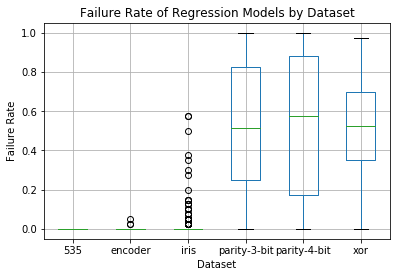

In [15]:
ax = df[using_regression].boxplot(column='fail_rate', by='dataset')
ax.set_ylabel('Failure Rate')
ax.set_xlabel('Dataset')
ax.set_title('Failure Rate of Regression Models by Dataset')
plt.suptitle('');  # get rid of the generic title pandas gives us.

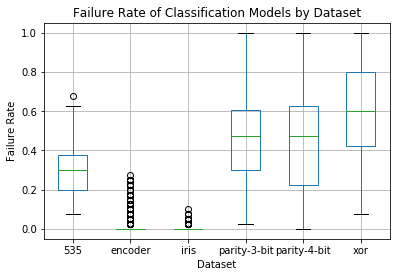

In [16]:
ax = df[using_classification].boxplot(column='fail_rate', by='dataset')
ax.set_ylabel('Failure Rate')
ax.set_xlabel('Dataset')
ax.set_title('Failure Rate of Classification Models by Dataset')
plt.suptitle('');  # get rid of the generic title pandas gives us.